In [1]:
from scipy.optimize import minimize
from scipy.optimize import Bounds
from scipy.optimize import LinearConstraint
import numpy as np
import pandas as pd

In [2]:
data = pd.read_csv('data_by_channels.csv')
print(data)

   chanel  price for the video  max number of videos
0       1                 1000                   110
1       2                  900                    60
2       3                 1200                    50
3       4                 1100                   150
4       5                  800                    50
5       6                 1150                    45


### 1.
Пусть у нас имеется фиксированный бюджет в 300 000 у.е. на всю
рекламную компанию. Какое должно быть распределение
бюджета по каналам, если мы хотим, чтобы на C hanne l1, C h anne l3,
C hanne l6 приходилось не менее 40% бюджета (суммарный
бюджет на эти каналы должен составлять 40% от общего и при
этом не важно как он распределяется внутри обозначенных
каналов), а общее количество роликов при этом было
максимально. (Решение должно быть найдено с использованием
специализированных под подобные задачи библиотек, а также
вручную, оперируя лишь стандартными библиотеками numpy и,
если потребуется pandas).

\begin{equation}
\begin{aligned}
    max(x_{1} + x_{2} + x_{3} + x_{4} + x_{5} + x_{6})\\
    1000 \cdot x_{1}+900 \cdot x_{2}+1200 \cdot x_{3}+1100 \cdot x_{4}+800 \cdot x_{5}+1150 \cdot x_{6} \leq 300000\\    
    1000 \cdot x_{1}+1200 \cdot x_{3}+1150 \cdot x_{6}\geq120000\\
    0\leq x_{1} \leq110\\
    0\leq x_{2} \leq60\\
    0\leq x_{3} \leq50\\
    0\leq x_{4} \leq150\\
    0\leq x_{5} \leq50\\
    0\leq x_{6} \leq45\\
\end{aligned}
\end{equation}

In [3]:
fun = lambda x: -(x.sum())
cons = ({'type': 'ineq', 'fun': lambda x: data.iloc[:,1].values.dot([x[0], 0, x[2], 0, 0, x[5]]) - 120000},
        {'type': 'ineq', 'fun': lambda x: -(data.iloc[:,1].values.dot(x)) + 300000})
bnds = []
for i in data.iloc[:,2].values:
    bnds.append((0,i))
res = minimize(fun, data.iloc[:,2].values, method='SLSQP', bounds=bnds,
                constraints=cons)

In [4]:
result = np.array([])
for x in res.x:
    result = np.hstack([result,round(x)])

print(data.iloc[:,1].values.dot(result),data.iloc[[0, 2, 5],1].values.dot(result[[0, 2, 5]]))

300150.0 120350.0


условие, чтобы на Channel1, Channel3, Channel6 приходилось не менее 40% бюджета, выполняктся, но мы привысили бюджет. Поэтому необходимо вычесть один ролик из 2,4,5 каналов, выберем самый дешевый ролик.

In [5]:
result[4] -= 1
data.iloc[:,1].values*result

array([110000.,  54000.,      0.,  85800.,  39200.,  10350.])

In [6]:
def norm(vec):
    #функция нормировки вектора
    norma = np.linalg.norm(vec)
    for i in range(len(vec)):
        vec[i] = vec[i]/norma;
    return vec

In [7]:
def f1(x):
    return np.array([float(x) for x in data.iloc[:,1].values]).dot(x) <= 300000

In [8]:
def f2(x):
    return np.array([float(data.iloc[i,1]) if i in [0,2,5] else 0. for i in range(6)]).dot(x) >= 120000

In [9]:
def maximize(x0):
    jac_cons1 = norm(np.array([float(-x) for x in data.iloc[:,1].values]))
    jac_cons2 = norm(np.array([float(data.iloc[i,1]) if i in [0,2,5] else 0. for i in range(6)]))
    
    for i in range(4000):
        jac_func = norm(np.array([1., 1., 1., 1., 1., 1.]))
        if( not f1(x0 + jac_func) ):
            jac_func = jac_func + jac_cons1
        if ( not f2(x0 + jac_func) ):
            jac_func += jac_cons2            
        x = x0 + jac_func
        if( x[0] >= 110 or x[0] <= 0):
            jac_func[0] = 0            
        if( x[1] >= 60 or x[1] <= 0):
            jac_func[1] = 0
        if( x[2] >= 50 or x[2] <= 0):
            jac_func[2] = 0            
        if( x[3] >= 150 or x[3] <= 0):
            jac_func[3] = 0            
        if( x[4] >= 50 or x[4] <= 0):
            jac_func[4] = 0           
        if( x[5] >=45 or x[5] <= 0):
            jac_func[5] = 0
        x0 += jac_func
    return x0

In [10]:
X0 = np.array([110., 60., 50., 150., 50., 45.])
res = maximize(X0)
result = np.array([])
for x in res:
    result = np.hstack([result,round(x)])

print(data.iloc[:,1].values.dot(result),data.iloc[[0, 2, 5],1].values.dot(result[[0, 2, 5]]))

297950.0 120350.0


При такой реализации получается небольшое занежение бюджета. Поэтому добавим один любой ролик.

In [11]:
result[3] += 1
data.iloc[:,1].values*result

array([110000.,  54000.,      0.,  84700.,  40000.,  10350.])

### 2.
Пусть у нас имеется фиксированный бюджет в 300 000 у.е. на всю
рекламную компанию. Какое должно быть распределение
бюджета по каналам, если мы хотим, чтобы на C hanne l1, C hanne l3,
C h anne l6 приходилось не менее 40% роликов, а общее количество
роликов при этом было максимально. (Решение должно быть
найдено с использованием специализированных под подобные
задачи библиотек, а также вручную, оперируя лишь стандартными
библиотеками numpy и, если потребуется pandas).

\begin{equation}
\begin{aligned}
    max(x_{1} + x_{2} + x_{3} + x_{4} + x_{5} + x_{6})\\
    1000 \cdot x_{1}+900 \cdot x_{2}+1200 \cdot x_{3}+1100 \cdot x_{4}+800 \cdot x_{5}+1150 \cdot x_{6} \leq 300000\\    
    x_{1}+x_{3}+x_{6}\geq 0.4*(x_{1}+x_{2}+x_{3}+x_{4}+x_{5}+x_{6})\\
    0\leq x_{1} \leq110\\
    0\leq x_{2} \leq60\\
    0\leq x_{3} \leq50\\
    0\leq x_{4} \leq150\\
    0\leq x_{5} \leq50\\
    0\leq x_{6} \leq45\\
\end{aligned}
\end{equation}

In [12]:
fun = lambda x: -(x.sum())
cons = ({'type': 'ineq', 'fun': lambda x: x[0] + x[2] + x[5] - 0.4*x.sum() },
        {'type': 'ineq', 'fun': lambda x: -(data.iloc[:,1].values.dot(x)) + 300000})
bnds = []
for i in data.iloc[:,2].values:
    bnds.append((0,i))
res = minimize(fun, data.iloc[:,2].values, method='SLSQP', bounds=bnds,
                constraints=cons)

In [13]:
result = np.array([])
for x in res.x:
    result = np.hstack([result,round(x)])

print(data.iloc[:,1].values.dot(result), result[[0,2,5]].sum()/result.sum())

300350.0 0.4006514657980456


In [14]:
result

array([110.,  60.,   0.,  74.,  50.,  13.])

 Здесь мы также привысили бюджет. Поэтому необходимо вычесть один ролик из 2,4,5 каналов, выберем самый дешевый ролик.

In [15]:
result[4] -= 1
data.iloc[:,1].values*result

array([110000.,  54000.,      0.,  81400.,  39200.,  14950.])

In [16]:
def f3(x):
    return 0.4*x.sum() <= x[[0,2,5]].sum()

In [17]:
def maximize_two(x0):
    jac_cons1 = norm(np.array([float(-x) for x in data.iloc[:,1].values]))
    jac_cons2 = norm(np.array([-0.6, -1., -0.6, -1., -1., -0.6]))
    
    for i in range(5000):
        jac_func = norm(np.array([1., 1., 1., 1., 1., 1.]))
        if( not f1(x0 + jac_func) ):
            jac_func = jac_func + jac_cons1
        if ( not f3(x0 + jac_func) ):
            jac_func += jac_cons2            
        x = x0 + jac_func
        if( x[0] >= 110 or x[0] <= 0):
            jac_func[0] = 0            
        if( x[1] >= 60 or x[1] <= 0):
            jac_func[1] = 0
        if( x[2] >= 50 or x[2] <= 0):
            jac_func[2] = 0            
        if( x[3] >= 150 or x[3] <= 0):
            jac_func[3] = 0            
        if( x[4] >= 50 or x[4] <= 0):
            jac_func[4] = 0           
        if( x[5] >=45 or x[5] <= 0):
            jac_func[5] = 0
        x0 += jac_func
    return x0

In [18]:
X0 = np.array([110., 60., 50., 150., 50., 45.])
res = maximize_two(X0)
result = np.array([])
for x in res:
    result = np.hstack([result,round(x)])

print(data.iloc[:,1].values.dot(result), result[[0,2,5]].sum()/result.sum())

298100.0 0.4


При такой реализации получается небольшое занежение бюджета. Поэтому добавим один любой ролик.

In [19]:
result[5] += 1
data.iloc[:,1].values*result

array([110000.,  54000.,      0.,  80300.,  40000.,  14950.])

### 3.
Написать на языке python скрипт, который позволяет найти локальный
минимум функции sin (atan ( y ) )∗sin (atan ( x ) )∗e (− x − y ). (Решение должно быть
найдено с использованием специализированных под подобные задачи
библиотек, а также вручную, оперируя лишь стандартными
библиотеками numpy и, если потребуется pandas).
Визуализация
оптимизируемой
функции
будет
являться
дополнительным преимуществом.

In [20]:
def func(x, y):
    return np.sin(np.arctan(y))*np.sin(np.arctan(x))*np.exp(-x**2 - y**2)

In [21]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.axes3d import Axes3D

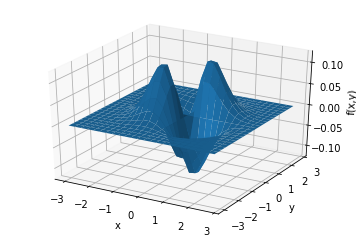

In [22]:
fig = plt.figure()
ax = fig.gca(projection='3d')

X = np.arange(-3, 3, 0.25)
Y = np.arange(-3, 3, 0.25)
X, Y = np.meshgrid(X, Y)
Z = func(X,Y)

surf = ax.plot_surface(X, Y, Z)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('f(x,y)')
plt.show()

Как видно из графика у функции имеются два минимума и в зависимости от выбора начальной точки мы можем получить разные решения.

In [23]:
optimal = minimize(lambda z: func(z[0],z[1]), [-1., 1.], method='L-BFGS-B', bounds=((-3, 3),(-3, 3)))
print(optimal.x, func(optimal.x[0], optimal.x[1]))

[-0.60500031  0.6050003 ] -0.12886258119189725


In [24]:
optimal = minimize(lambda z: func(z[0],z[1]), [1., -1.], method='L-BFGS-B', bounds=((-3, 3),(-3, 3)))
print(optimal.x, func(optimal.x[0], optimal.x[1]))

[ 0.6050003  -0.60500031] -0.12886258119189725


In [25]:
def jac_func(x, y):
    df_dx = np.sin(np.arctan(y))*np.exp(-x**2 - y**2)*( np.cos(np.arctan(x))*(1./(1. + x**2)) -
                                                       np.sin(np.arctan(x))*2*x )
    
    df_dy = np.sin(np.arctan(x))*np.exp(-x**2 - y**2)*( np.cos(np.arctan(y))*(1./(1. + y**2)) -
                                                       np.sin(np.arctan(y))*2*y )
    return np.array([df_dx, df_dy])

In [30]:
def minimum(x0):
    f = 1000 
    while(f > func(x0[0], x0[1])):
        f = func(x0[0], x0[1])
        grad = jac_func(x0[0], x0[1])
        x0 -= 0.01*grad
    return x0

In [31]:
optimal = minimum([1., -1.0])
print(optimal, func(optimal[0], optimal[1]))

[ 0.60500043 -0.60500043] -0.12886258119189184


In [32]:
optimal = minimum([-1., 1.0])
print(optimal, func(optimal[0], optimal[1]))

[-0.60500043  0.60500043] -0.12886258119189184
